# University of Aberdeen

## Applied AI (CS5079)

### Assessment 1 Task 3 - Reinforcement Learning by mixing Screen and RAM

---


## Imports

In [ ]:
# OpenAI has preprocessing modules in their baselines repository 
# such as FrameStack, NoopResetEnv, episode_life, etc.
# To import those we first need to install the OpenAI baseline package
# via running this code cell.
!pip install git+https://github.com/openai/baselines.git

In [2]:
# Seed value used for achieving reproducibility
SEED_VALUE = 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# For handling files
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

# https://github.com/openai/baselines
from baselines.common.atari_wrappers import make_atari, wrap_deepmind, NoopResetEnv, FrameStack

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym

# The frame stack size
FRAME_STACK_SIZE = 5

# Make the Atari games and their environment assign it to
# a variable for later use (RL of the DDQN agent).
env = gym.make("Asterix-v0")
env_ram = gym.make("Asterix-ram-v0")
# Preprocess the environments (downsampling to 84x84 and
# scaling the input image pixels of the game)
env = wrap_deepmind(env, frame_stack=False, scale=True, clip_rewards=False, episode_life=False)

# Stack the input image frames by FRAME_STACK_SIZE
env = FrameStack(env, FRAME_STACK_SIZE)
env_ram = FrameStack(env_ram, FRAME_STACK_SIZE)
# Seed the Atari game environments
env.seed(SEED_VALUE), env_ram.seed(SEED_VALUE)

([1337, 17452119], [1337, 17452119])

In [3]:
# Print the observation and action spaces, and the Atari 
# game action space and their names (meanings)
print("Observation spaces:")
print(f"\tImage: {env.observation_space.shape}\n\tRAM: {env_ram.observation_space.shape}")
print("Action space:", env.action_space)
print("Possible actions:", env.unwrapped.get_action_meanings())

Observation spaces:
	Image: (84, 84, 5)
	RAM: (640,)
Action space: Discrete(9)
Possible actions: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


## Task 3.1

For architecture, refer to report appendix.

In [4]:
# Import the garbage collector package
import gc

def reset_random_seeds():
    """Reset the random number generator seed to achieve full reproducibility 
    even when running the script on GPU
    """
    
    # Set the environment determinism to guarantee
    # reproducibility of the results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    
    # Perform garbage collection
    gc.collect()
    print("Random number generator seed reset!")  # optional

### Defining global variable and importing packages for training the models

In [5]:
SCALE = 255

In [6]:
def normalise(ram, scale):
    return ram/scale

In [7]:
# Import the Keras layer used for building our DDQN models
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform

# Get the image and RAM input shapes
# for the DDQN models (game environment observation space)
IMG_INPUT_SHAPE = env.observation_space.shape
RAM_INPUT_SHAPE = env_ram.observation_space.shape

# Get the output shape for the DDQN models
NUM_ACTIONS = env.action_space.n

# Set the batch size
BATCH_SIZE = 32

# Set the DDQN agent memory size.
# We use a relatively small value due to assessment time constraints
# and also to provide easier reproducibility. ===================================
MEMORY_SIZE = 25000

# Define the exploration steps of the DDQN agent.
# We do not train the model during these first steps.
EXPLORATION_STEPS = 20000

# Define the learning rate to be used for the model
# gradient descent optimisation method (Adam as opposed to RMSprop) WHY ADAM??===============================
LEARNING_RATE = 0.00025

In [8]:
class SumTree:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    Args:
        capacity (int): size of the sum tree
    """
    # The data pointer class variable
    write = 0

    def __init__(self, capacity):
        """Initialize the tree with all nodes and data with values set to 0.
        """
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema above
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        # Store the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)

    def _propagate(self, idx, change):
        """Recursively propagate a given child node change through the sum tree.
        """
        
        # Get the parent node index
        parent = (idx - 1) // 2
        
        # Apply the child node change to the parent node
        self.tree[parent] += change
        
        # Do this until the root node is reached
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        """Return a leaf node (priority) index for the current experience (observation)
        """
        
        # Get the left and right child node indexes
        # for the current sample
        left = 2 * idx + 1
        right = left + 1
        
        # Return the index itself if the 
        # left child index is greater than the 
        # capacity of the sum tree
        if left >= len(self.tree):
            return idx
        
        # Start recursion
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        """Return the root node (total sum of the experience priority values).
        """
        return self.tree[0]

    def add(self, p, data):
        """Add the experience and its priority score (as a leaf) to the sum tree.
        """
        # Get the tree index for the experience (observation)
        idx = self.write + self.capacity - 1
        
        # Update the sum tree data
        self.data[self.write] = data
        
        # Update the sum tree probability values
        self.update(idx, p)
        
        # Increment the data pointer
        self.write += 1
        
        # If over the capacity, go back to first index (we overwrite)
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        """Update the leaf priority score and propagate the change through tree.
        """
        # Change = new priority score - former priority score
        change = p - self.tree[idx]
        self.tree[idx] = p
        
        # Propagate the change through tree
        self._propagate(idx, change)

    def get(self, s):
        """Return the leaf index, priority value and its associated experience (observation).
        """
        # Get the leaf index
        idx = self._retrieve(0, s)
        
        # Get the experience (observation) index
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])
    

#-------------------- MEMORY --------------------------
class Memory:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    
    Args:
        capacity (int): size of the sum tree
    """
    # Hyperparameter to avoid assigning 0 probability to experiences
    e = 0.01
    
    # Hyperparameter to make a trade-off between random sampling and taking a
    # a high priority experience (observation)
    a = 0.6

    def __init__(self, capacity):
        """Initialise the sum tree with the given capacity.
        """
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        """Store a new experience in the tree along with its corresponding priority value.
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Store the priority and the experience (observation)
        self.tree.add(p, sample) 

    def sample(self, n):
        """Sample a n-sized batch of priority index and observation pair.
        """
        # Create a list to hold the batch pairs
        batch = []
        
        # Calculate and store the priority segment
        segment = self.tree.total() / n
        
        # Populate the batch list
        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        """Update the sum tree leaves (priorities).
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Update the sum tree probability values
        self.tree.update(idx, p)

In [14]:
# Import the math Python package
import math

# Minimum and maximum epsilon value constants
MAX_EPSILON = 1
MIN_EPSILON = 0.1

# Constant that determines the speed of the epsilon decay
LAMBDA = - math.log(0.01) / EXPLORATION_STEPS 

class DDQNAgent():
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an DDQ Network and Agent experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/jaromiru/AI-blog
    
    Args:
        lr (float): learning rate of the network
    """
    steps = 0
    
    def __init__(self, lr=LEARNING_RATE):
        """Initialise the agent and the online and target DDQNs for the environment.
        """
        # The DDQN agent learning rate attribute
        # used for the Adam optimiser when building 
        # our model architecture.
        self.lr = lr
        
        # DDQN agent memory represented by a SumTree class instance
        # (faster batch sampling, thus, better runtime performance)
        self.memory = Memory(MEMORY_SIZE)
        
        # Set the initial DDQN models loss value to be +inf
        self.loss_val = np.inf
        self.action_space = NUM_ACTIONS
        
        # Disable eager execution which boosts runtime
        # Eager execution is generally used for debugging purposes
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99

        # Create the two networks for predicting the actions
        
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 10,000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()


    def q_network(self, filters_1=32, filters_2=64, filters_3=64):
        """Define and return the mixed (image frame + RAM state) input model architecture. 
        We shift from Sequential configuration to a functional one. This approach is used 
        when handling models with non-linear topology, shared layers, multiple inputs/outputs.
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        reset_random_seeds()

        # Build the model
        # Define the kernel initialiser. We adopt the He uniform
        # variance scaling initialiser for improved training stability.
        kernel_init = HeUniform()
        
        # Define the RAM input layer
        img_input = Input(shape=IMG_INPUT_SHAPE)
        
        # Set the Conv2D layers
        conv_lyr = Conv2D(filters_1, kernel_size=8, padding="same", strides=4, activation='relu', kernel_initializer=kernel_init)(img_input)
        conv_lyr = Conv2D(filters_2, kernel_size=4, padding="same", strides=2, activation='relu', kernel_initializer=kernel_init)(conv_lyr)
        conv_lyr = Conv2D(filters_3, kernel_size=3, padding="same", strides=1, activation='relu', kernel_initializer=kernel_init)(conv_lyr)
        flatten_lyr = Flatten()(conv_lyr)
        
        # Define the RAM input layer
        ram_input = Input(shape=RAM_INPUT_SHAPE)
        
        # Merge the Conv2D and Dense layer outputs into a single large vector via concatenation
        concat_lyr = concatenate([flatten_lyr, ram_input])
        
        # We pass RAM environment states as the inputs to our Dense layers 
        dense_lyr = Dense(512, activation='relu', kernel_initializer=kernel_init)(concat_lyr)
        dense_lyr = Dense(256, activation='relu', kernel_initializer=kernel_init)(dense_lyr)
        
        # Pass the concatenated tensor the the last Dense output layer
        output_lyr = Dense(NUM_ACTIONS, activation="linear", kernel_initializer=kernel_init)(dense_lyr)
        
        # Specify the inputs and outputs of our mixed model architecture
        model = Model(inputs=[img_input, ram_input], outputs=output_lyr)
        
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
#         model.summary()
        return model
            
    def update_target(self):
        """Update the target network with the online mixed network weights.
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, img_state, ram_state, step):
        """Based on the epsilon agent chooses whether to explore the environment
        or exploit the current image and RAM game states.
        """
        if step <= EXPLORATION_STEPS:
            return np.random.randint(self.action_space)
        else:     
            self.steps += 1
            epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)
            if np.random.rand() < epsilon:
                return np.random.randint(self.action_space)# random action
            else:
                q_values = self.online.predict([img_state.reshape(-1, *IMG_INPUT_SHAPE),\
                                                ram_state.reshape(-1, *RAM_INPUT_SHAPE)])
                return np.argmax(q_values) # optimal action
    
    def get_train_data(self, batch):
        """Decide on the input, desired output and error of the current state.
        Use the batch of image and RAM state input samples.
        """
        
        # NumPy array storing no observation space
        # used at the end of each episode (improved performance)
        img_no_state = np.zeros(IMG_INPUT_SHAPE)
        ram_no_state = np.zeros(RAM_INPUT_SHAPE)
        
        # Get the image and RAM previous states from the batch observations
        prev_img_states = np.array([sample_list[0][0] for _, sample_list in batch])
        prev_ram_states = np.array([sample_list[1][0] for _, sample_list in batch])
        
        # Get the image and RAM next states from the batch observations
        # No state if done = True
        img_next_states = np.array([(img_no_state if sample_list[0][4] is True else sample_list[0][3]) for _, sample_list in batch])
        ram_next_states = np.array([(ram_no_state if sample_list[1][4] is True else sample_list[1][3]) for _, sample_list in batch])
        
        # Make predictions based on the previous states
        # using the online model
        prev_q_vals = self.online.predict([prev_img_states, prev_ram_states])
        
        # Make predictions based on the next states
        # using the online model (used in the function for 
        # calculating the future q values of the DDQN)
        next_q_vals_double = self.online.predict([img_next_states, ram_next_states])
        
        # Make predictions based on the next states
        # using the target model
        next_q_vals = self.target.predict([img_next_states, ram_next_states])
        
        # Create NumPy arrays for storing the previous states and future q values,
        # and the calculated error values (used for determining state priorities)
        # respectively
        img_X = np.zeros((len(batch), *IMG_INPUT_SHAPE))
        ram_X = np.zeros((len(batch), *RAM_INPUT_SHAPE))
        Y = np.zeros((len(batch), NUM_ACTIONS))
        errors = np.zeros(len(batch))
        
        for idx in range(len(batch)):
            
            # Get the sample list from the batch
            sample_list = batch[idx][1]
            
            # Unpack the current batch samples
            curr_img_state, action, reward, _, done = sample_list[0]
            curr_ram_state, _, _, _, _ = sample_list[1]
            
            # Get the current (previous/old) state q value
            q_val = prev_q_vals[idx]
            prev_q_val = q_val[action]
            
            # Future q value is the current q val
            # which is to be updated using the predictions of
            # both the online and the target models
            future_q_val = q_val
            
            # Update the future q value
            if done:
                future_q_val[action] = reward
            else:
                future_q_val[action] = reward + next_q_vals[idx][np.argmax(next_q_vals_double[idx])] * self.discount_rate
            
            # Populate the previous state and future q value lists 
            img_X[idx] = curr_img_state
            ram_X[idx] = curr_ram_state
            Y[idx] = future_q_val
            
            # Calculate the error values for each experience (observation)
            errors[idx] = abs(prev_q_val - future_q_val[action])
        
        return ([img_X, ram_X], Y, errors)
    
    def save_to_memory(self, img_sample, ram_sample, step):
        """Update the sum tree priorities and observations (samples).
        """
        sample_list = [img_sample, ram_sample]
        if step <= EXPLORATION_STEPS:
            error = abs(img_sample[2])  # Reward
            self.memory.add(error, sample_list)
        else:
            X, Y, errors = self.get_train_data([(0, sample_list)])
            self.memory.add(errors[0], sample_list)
        
    def train(self, step):
        """Train the online model and update the loss value.
        """
        
        # Sample a batch error-observation pairs
        batch = self.memory.sample(BATCH_SIZE)
        X, Y, errors = self.get_train_data(batch)
        
        # Update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])
        
        # Fit the online DDQN and update the loss value
        hist = self.online.fit(X, Y, batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    


Please refer to the report for further information regarding the deployment and parameter adjustments of the agent.

## Task 3.2

In [15]:
import time

# Initialise the DDQN agent 
ddqn_agent = DDQNAgent()  

# Lists to hold the steps and their corresponding rewards respectively 
ep_steps, ep_rewards = [], []

# To hold the total episode reward of the agent
total_reward = 0

# Total number of training steps
N_STEPS = 1000000  

# Train the DDQN agent after 4 actions
TRAIN_ONLINE_STEPS = 4

# Update the target DDQN every 10,000 steps (1 epoch)
# Considered as a hyperparameter
UPDATE_TARGET_STEPS = 10000

# Start the DDQN agent game exploration and training loop
done=True
for step in range(N_STEPS):
    
    # Calculate the DDQN agent training process
    # completion as percentage
    total_perc = step * 100 / N_STEPS
    
    # Print the current step, total number of training steps, training process percentage and DDQN loss value
    print(f"\r\tAction step: {step}/{N_STEPS} ({total_perc:.2f}%)\tLoss: {ddqn_agent.loss_val:5f}", end="")
    
    # Reset the game environments once the ddqn_agent
    # is out of lives
    if done:
        
        # Calculate the average reward for the episode (for 3 lives)
        avg_reward = int(total_reward/3)
        
        # Append the total reward and episode steps
        # used later for plotting and printing
        if step:
            ep_rewards.append(total_reward)
            ep_steps.append(step)
        
        # Print the most recent average (mean) episode and total (all episodes so far) reward values 
        print(f"\tAVG reward: {avg_reward}\tTotal mean: {np.mean(ep_rewards)}")
        
        # Reset the game environments and get the initial observations
        img_res = env.reset()
        ram_res = env_ram.reset()
        
        
        # Convert the observations to NumPy arrays
        # since we need such arrays to carry out the ddqn_agent training
        img_state = np.array(img_res)
        ram_state = normalise(np.array(ram_res), SCALE)
        
        # Reset the total episode reward since
        # we start a new episode
        total_reward = 0


    # Get a exploration/exploitation action
    action = ddqn_agent.get_action(img_state, ram_state, step)

    # Take a step in the game environments
    img_next_state, reward, done, _ = env.step(action)
    ram_next_state, _, _, _ = env_ram.step(action)
    
    # Convert to NumPy arrays and normalise the RAM input state
    img_next_state = np.array(img_next_state)
    ram_next_state = normalise(np.array(ram_next_state), SCALE)
    
    img_sample = (img_state, action, reward, img_next_state, done)
    ram_sample = (ram_state, action, reward, ram_next_state, done)
    
    # Update the sum tree priorities and observations (samples)
    ddqn_agent.save_to_memory(img_sample, ram_sample, step)
    
    # Skip training the DDQN agent if still exploring
    if step > EXPLORATION_STEPS:
        
        # Train the online DDQN every 4th frame
        if step % TRAIN_ONLINE_STEPS == 0:
            ddqn_agent.train(step)

        # Regularly (every 10000 steps) copy the online DDQN to the target DDQN
        if step % UPDATE_TARGET_STEPS == 0:
            ddqn_agent.update_target()
    
    # Render the game environment
#     env.render()
    
    # Increment the total reward by the current reward
    total_reward += reward
    
    # Assing the current states to the next states
    img_state = img_next_state
    ram_state = ram_next_state

# Close the game environment 
env.close()

Random number generator seed reset!
Random number generator seed reset!
	Action step: 0/1000000 (0.00%)	Loss:   inf	AVG reward: 0	Total mean: nan
	Action step: 293/1000000 (0.03%)	Loss:   inf	AVG reward: 66	Total mean: 200.0
	Action step: 809/1000000 (0.08%)	Loss:   inf	AVG reward: 183	Total mean: 375.0
	Action step: 1246/1000000 (0.12%)	Loss:   inf	AVG reward: 150	Total mean: 400.0
	Action step: 1546/1000000 (0.15%)	Loss:   inf	AVG reward: 50	Total mean: 337.5
	Action step: 1844/1000000 (0.18%)	Loss:   inf	AVG reward: 50	Total mean: 300.0
	Action step: 2229/1000000 (0.22%)	Loss:   inf	AVG reward: 133	Total mean: 316.6666666666667
	Action step: 2603/1000000 (0.26%)	Loss:   inf	AVG reward: 133	Total mean: 328.57142857142856
	Action step: 2893/1000000 (0.29%)	Loss:   inf	AVG reward: 66	Total mean: 312.5
	Action step: 3212/1000000 (0.32%)	Loss:   inf	AVG reward: 150	Total mean: 327.77777777777777
	Action step: 3482/1000000 (0.35%)	Loss:   inf	AVG reward: 50	Total mean: 310.0
	Action step:

KeyboardInterrupt: 

In [17]:
ddqn_online = ddqn_agent.online
ddqn_agent.online.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 84, 84, 5)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 21, 21, 32)   10272       ['input_5[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 11, 11, 64)   32832       ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 11, 11, 64)   36928       ['conv2d_7[0][0]']               
                                                                                            

## Plotting

In [11]:
# Import the Pandas Python package
# used to create data frame to store
# DDQN agent training data
import pandas as pd
# train_df = pd.read_csv('ddqn_data_final.csv')
# train_df.iloc[:, 1:]
# Create data frame for the obtained training data
train_df = pd.DataFrame(data={'Step': ep_steps, 'Reward': ep_rewards})

# Calculate cumulative mean of the rewards
train_df['Total Mean'] = train_df['Reward'].expanding().mean()

# Calculate cumulative sum of the rewards
train_df['Total Reward'] = train_df['Reward'].cumsum()
train_df.tail(n=5)

,Step,Reward,Total Mean,Total Reward
2384,997459,100.0,587.044025,1400100.0
2385,998250,1150.0,587.279966,1401250.0
2386,998713,650.0,587.306242,1401900.0
2387,999077,200.0,587.144054,1402100.0
2388,999619,700.0,587.191293,1402800.0


In [12]:
def plot_df(df, cols, x_label, y_label, title, title_fontsize=20, label_fontsize=16):
    """Plot the DDQN agent training data by given columns.
    """
    plt.rcParams['figure.figsize']= (20, 6)
    for col in cols:
        df[col].plot(fontsize=12)
    plt.legend(loc=2, prop={'size': 14})
    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.show()

In [13]:
def plot_boxplot(df, cols, models, x_label, y_label, title, title_fontsize=20, label_fontsize=16):
    """Plot a boxplot of the DDQN agent training data by given columns.
    """
    plt.rcParams['figure.figsize']= (10, 7)
    initial_labels = []
    final_labels = []
    for idx, model in enumerate(models):
        initial_labels.append(idx+1)
        final_labels.append(model)
    df[cols].boxplot(fontsize=12)
    plt.xticks(initial_labels, final_labels)
    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.show()

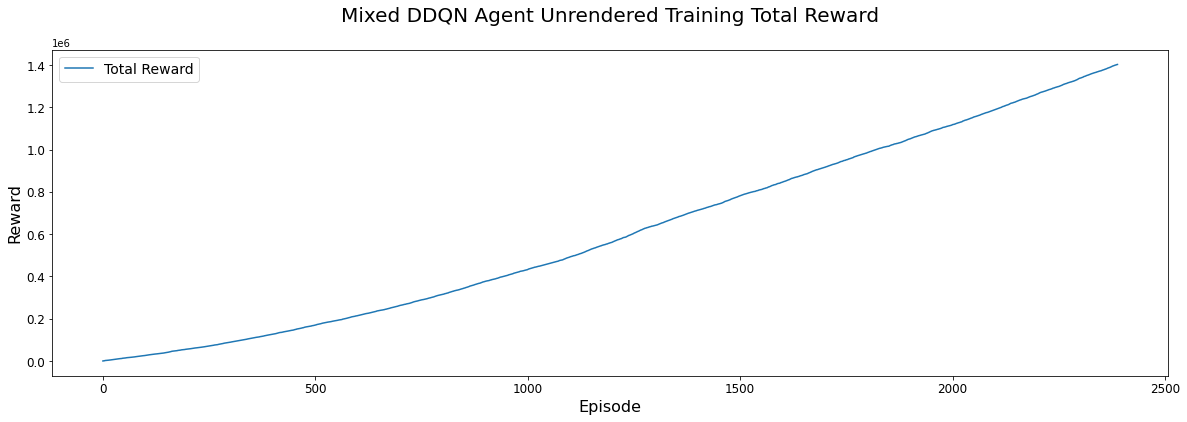

In [14]:
# Plot the training reward cumulative sum throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, cols=['Total Reward'], x_label='Episode', y_label='Reward',\
        title='Mixed DDQN Agent Unrendered Training Total Reward\n')

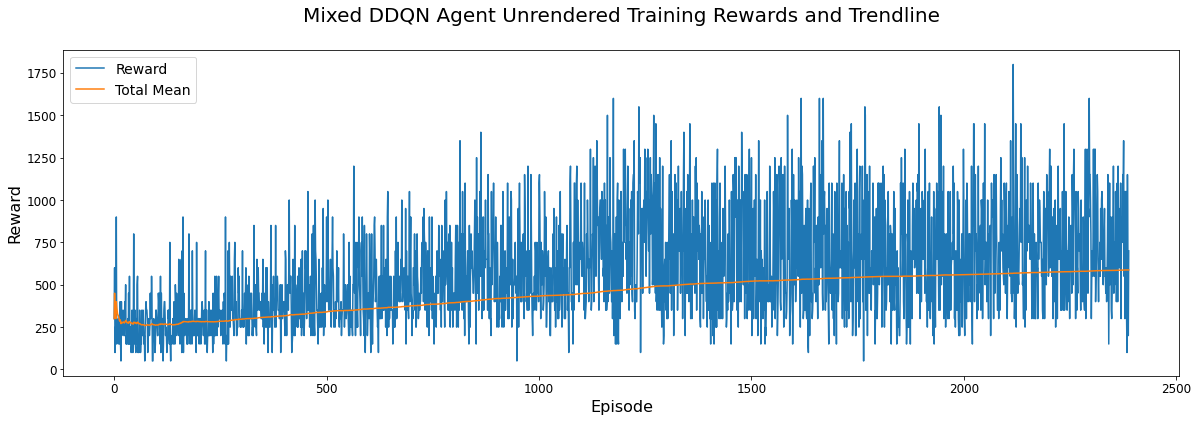

In [15]:
# Plot the training reward values throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, cols=['Reward', 'Total Mean'], x_label='Episode', y_label='Reward',\
        title='Mixed DDQN Agent Unrendered Training Rewards and Trendline\n')

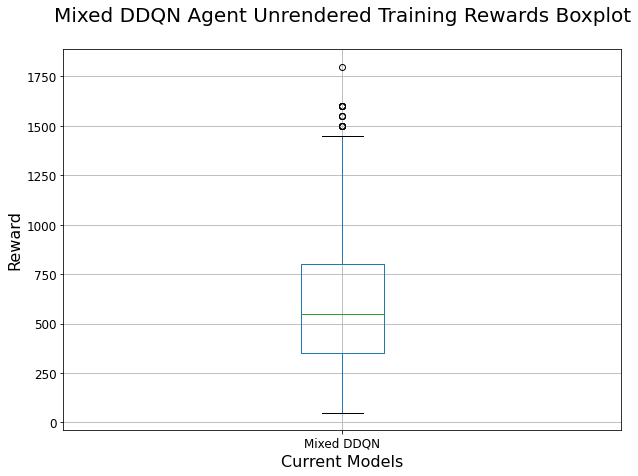

In [16]:
# Display a boxplot of the DDQN agent training data (agent rewards)
plot_boxplot(train_df, ['Reward'], ['Mixed DDQN'], x_label='Current Models', y_label='Reward',\
             title='Mixed DDQN Agent Unrendered Training Rewards Boxplot\n')

In [17]:
# Save the obtaine DDQN training data to a CSV file
train_df.to_csv('mixed_ddqn_unrendered.csv')

In [18]:
# Create a HDF5 file with the trained online model
# with all the details necessary to reconstitute it. 
ddqn_online = ddqn_agent.online
ddqn_online.save('mixed_ddqn_online_unrendered.h5') 

# Create a HDF5 file with the trained target model
# with all the details necessary to reconstitute it. 
ddqn_target = ddqn_agent.target
ddqn_target.save('mixed_ddqn_target_unrendered.h5')
ddqn_online.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 84, 84, 5)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 21, 21, 32)   10272       ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 11, 11, 64)   32832       ['conv2d[0][0]']                 
                                                                                                  
 input_2 (InputLayer)           [(None, 640)]        0           []                               
                                                                                              

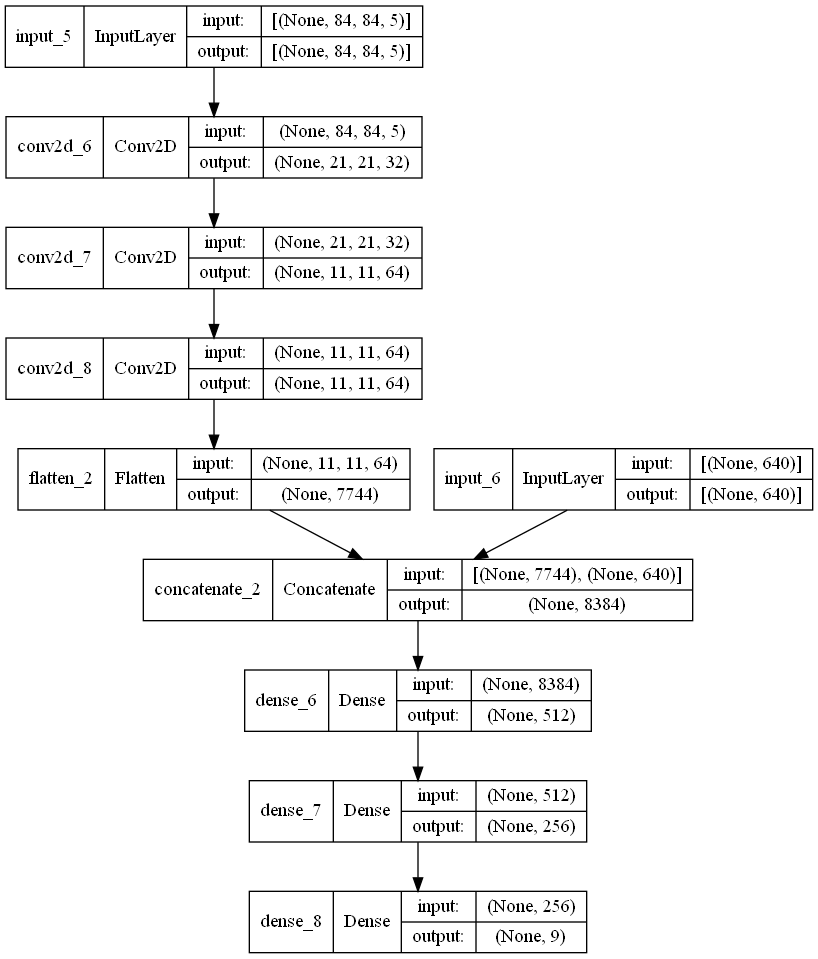

In [18]:
from tensorflow.keras.utils import plot_model

# Plot the mixed input DDQN and save it to a PNG file
plot_model(ddqn_online, to_file="architecture/mixed__v2_ddqn.png", show_shapes=True)

## Task 3.3

For the comparison, please refer to Notebook `Plots` in the folder Assessment1 which contains all performed experiments. 